#Assignment 1: Vision Transformer
In this lab you will build a vision transformer and train it on the CIFAR-10 dataset.
![](https://github.com/tonyscan6003/etivities/blob/main/vit.JPG?raw=true)

A key problem with using transformers with images is long sequence lengths when each pixel is used as an individual token. As the computational complexity of transformers scales quadratically with sequence length, approaches to reduce the computation are required. The vision transformer solves this problem by dividing the image into a shorter sequence of patches that are converted to tokens with a dimension D.

Unlike convolution which inherently retains spatial information, the transformer self attention mechanism will compute the same result regardless of the order of the tokens. For this reason a sinusoidal positional encoding is included to retain positional information.  

The vision transformer can be trained on CIFAR-10 using supervised learning. A final classification layer is applied to the learned classification token. (We note that due to self attention, this token obtains information from the input patches and can therefore determine the class)

Note on this assignment:
* The goal of the assignment is to successfully code the transformer (not to achieve high the highest possible performance or optimise the training).  
* The Projection of the patches and positional encoding blocks is given in the notebook.
* It is recommended to take a hierachical approach to building the vision transformer.
 * Start with the lowest level self-attention block, then add multi-head attention, the transformer encoder and finally a toplevel vision transformer block.
 * Each block can be structured as a sub-class of nn.module. Instances of these classes can then be called into classes for higher level blocks (e.g. multi-head attention will create instances of the attention block)  
 * Take particular care with the dimensions of the token tensors. The pytorch layers such as nn.linear operate on the last dimension of the tensor. Therefore we want the features of the token ("D" dimension) to the be the last dimension.
 * You may want to initally use a small dimensionality D in your model when de-bugging as it will run more quickly.


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
import numpy as np

In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import torch
use_cuda = torch.cuda.is_available()

if not use_cuda:
	exit()

print(torch.cuda.get_device_name(0))
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
print('Memory Usage:')
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA RTX 4000 Ada Generation
__CUDNN VERSION: 90400
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA RTX 4000 Ada Generation
__CUDA Device Total Memory [GB]: 21.469069312
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Import Dataset
The [torchvision](https://pytorch.org/vision/stable/index.html) package (imported above) makes available several common image classification, object detection, semantic segmentation datasets, aswell as other [datasets](https://pytorch.org/vision/stable/datasets.html) for common computer vision applications.  

You can adjust these transforms as part of your regularisation strategy for the network. (Note that only the train_transform should be modified, we don't want to apply augmentation to the test set)

In [4]:
'''
train_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
'''

train_transforms = v2.Compose([
    v2.RandomResizedCrop(size=32,scale=(0.8,1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

#v2.RandomRotation(degrees=(-45, 45)),

In [5]:
# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transforms,
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transforms,
)

Files already downloaded and verified
Files already downloaded and verified


The `Dataset` is passed as an argument to `DataLoader`. This wraps an
iterable over the dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading.

In [6]:
batch_size = 128
batch_size = 256

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
Shape of y: torch.Size([256]) torch.int64


In [7]:
print('Test Samples ',len(test_dataloader.dataset))
print('Train Samples ',len(train_dataloader.dataset))
print('Test Batches ',len(test_dataloader))
print('Train Batches ',len(train_dataloader))

Test Samples  10000
Train Samples  50000
Test Batches  40
Train Batches  196


In [8]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

def plot_examples(image_batch,labels_batch,pred_labels_batch):
  n_plots = 12 # number of plots
  f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

  for i, image in enumerate(image_batch[0:n_plots,:,:,:]):
    # return image to cpu for display and permute to channels last
    disp_image =  torch.permute(image.to('cpu'),(2,1,0)).numpy()

    # Correct mean/std for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    disp_image = std * disp_image + mean
    disp_image = np.clip(disp_image, 0, 1)

    #
    axarr[i].imshow(disp_image[:,:,:])
    axarr[i].axis("off")
    #predicted, actual = classes[pred_labels_batch[0,i]], classes[labels_batch[i]]
    predicted, actual = classes[pred_labels_batch.to('cpu')[i]], classes[labels_batch.to('cpu')[i]]
    color = 'black' if predicted == actual else 'red'
    axarr[i].set_title(predicted,fontsize='small', color=color)




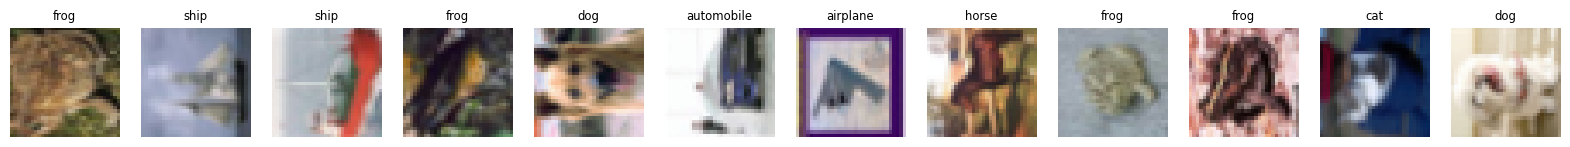

In [9]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Call plot with pred_label_batch = labels_batch before training
plot_examples(image_batch,labels_batch,labels_batch)

# Define Transformer Model

It is necssary to define a series of blocks to train the transformer model


*   1. Patch Embedding (included)
*   2. Positional Encoding (included)
*   3. Attention block
*   4. Multi head attention
*   5. Transformer Encoder
*   6. Vision Transformer (top level)



1. Patch Embedding:

This block could be implemented by first dividing the the image into patches (with an image processing function) and then applying the same linear layer to each patch. However this block is most efficiently implemented as a convolution followed by permute and flatten operations which achieves the same result.
* The convolution applies the same set of weights to a patch of the image. converting the patch to an embedding or token (after permute and flatten operations) . The number of kernels used in the convolution sets the dimensionality of the token.
* The convolution uses a large patch size and a stride equal to the patch size. The number of patches sets the number of tokens at the input to the vision transformer.
* The number of patches to be used can be determined from the guide to convolutional arithmetic (relationship no 5. No zero padding,non-unit strides) o = (i-k)/s +1 the ouptut size (for one dimension). We typically try to choose the patch size so that an integer number of patches are obtained. For example if i=32, and if we choose a patch size of k=8, and using the same stride as the patch size s=8 (no overlapping) then o=(32-8)/8+1=24/8+1=3+1=4 so there will be 4 patches along each dimension of the input image (so 16 patches in total).

In [10]:

class Patch_embedding(nn.Module):
    def __init__(self,in_channels,d_transformer,patch_size):
        super().__init__()
        self.in_channels = in_channels       # number of channels (C) in input
        self.d_transformer = d_transformer   # number of dimensions (D) in token (same as number of kernels in convolution)
        self.patch_size = patch_size         # Size of patch in pixels

        self.conv = nn.Conv2d(self.in_channels,self.d_transformer,self.patch_size,stride=self.patch_size,padding='valid')

    def forward(self, x):

        int_1 = self.conv(x)  # Input B x C x n x m converted to B x D x m'x n'
                              # where m' and n' is spatial size after convolution

        int_2 = torch.permute(int_1,(0,2,3,1))  # Use permute to make channels last B x m'x n' x D
        emb = torch.flatten(int_2,start_dim=1,end_dim=2)  # Flattent to B x N x D where N is sequence length (equal to no patches)
        return emb





2. Positional Encoding

* A good explanation for positional encoding and the use of sinusoidal functions to achieve this is detailed in the [hugginface blog](https://huggingface.co/blog/designing-positional-encoding). The matrix of positional values `pi_matrix` is created using torch cos and sin functions.
* We note that this matrix is assigned as [register_buffer](https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723). This allows us to use this matrix of values in the model (on the GPU), but they are not stored as learned parameters.

* Finally we note that this block creates the classification token. This token is defined as learned parameter using [nn.parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html). The classification token will increase the number of tokens by 1 over the number of patches. This token is passed through the self-attention blocks and receives information from other patches. It can be used to predict classes at the output.

In [11]:

class Positional_encoding(nn.Module):
    def __init__(self,d_transformer,n_patches):
        super().__init__()
        self.D = d_transformer   # number of dimensions (D) in token
        self.n_patches = n_patches   # number of patches in input
        self.N = self.n_patches+1     # number of tokens (N) in sequence including CLS token

        self.class_token = torch.nn.Parameter(torch.randn(1, 1, self.D))   # Learned embedding token

        # Create matrix PI of values that can be multiplied against the input token x in forward method
        # Matrix must be of size B x N x D
        pi_matrix = torch.zeros(self.N,self.D)
        for pos in range(self.N):
            for i in range(self.D):
              if i % 2 == 0:
                pi_matrix[pos,i] = torch.cos(torch.tensor(pos/(10000**(2*i/self.D))))
              else:
                pi_matrix[pos,i] = torch.sin(torch.tensor(pos/(10000**(2*i/self.D))))

        self.register_buffer('pi_matrix', pi_matrix, persistent = False)


    def forward(self, x):
        # Expand the cls tensor across the batch dimension and contactenate with input
        exp_cls = self.class_token.expand(x.size()[0], -1, -1)
        x = torch.cat((exp_cls,x),dim=1)
        # Add the positional encoding to the input tokens
        mult_pe = x+self.pi_matrix

        return mult_pe



In [12]:
numChannels = 3
patchSize = 8
numDims = 24

PatchEmbedding = Patch_embedding(numChannels,numDims,patchSize)
emb = PatchEmbedding(image_batch)
print(emb.shape)

torch.Size([256, 16, 24])


In [13]:
PositionalEncoding = Positional_encoding(24,16)
pe = PositionalEncoding(emb)
print(pe.shape)

torch.Size([256, 17, 24])


3. Attention Head

In [14]:
# Class to define attention head
# step 1. Operates on a sequence of tokens of size K=8 x1 to xn where n = 17 
# step 2. Learned weights for Q,K,V
# step 3. dot product ok K.T with Q
#step 4. Normalise attention
# step 5 Scalar multiply of V with attention  

class attentionHead(nn.Module):
    def __init__(self,embSize,numHeads,numPatchs):
        super().__init__()

        self.D = int(embSize/numHeads)
        self.P = numPatchs
        self.Q = nn.Linear(self.D,self.D)
        self.K = nn.Linear(self.D,self.D)
        self.V = nn.Linear(self.D,self.D)
        print("selfs ",self.D,self.P)
        
    def forward(self,x):
        q = self.Q(x)
#        print("q is ",q)
        k = self.K(x)
        v = self.V(x)
 
        kTranspose = k.T
#        print("shapes ", kTranspose.shape,q.shape)
# dot product of K.T with q
#        kq_scaled = torch.mm(kTranspose,q) / np.sqrt(self.tokenLength)
#        kq_scaled = torch.mm(q,kTranspose) / np.sqrt(self.tokenLength)
        kq_scaled = torch.bmm(q,k.transpose(1,2))

        
        normedAttn = nn.functional.softmax(kq_scaled,dim=1)

#        print("kq is ",kq_scaled)

#        print("normed attn ",normedAttn)

        SA_X = torch.bmm(normedAttn,v)

#        print("SA[x] ", SA_X.shape)

        

        return SA_X


            



4. Multi-Head Attention

In [15]:

 class MultiHeadattention(nn.Module):
    def __init__(self,tokenLength,numHeads,numPatchs):
        super().__init__()

        self.D = tokenLength 
        self.H = numHeads
        self.P = numPatchs
        embSize = int(self.D/self.H)
#        print("embsize ",embSize)
        self.mha = nn.ModuleList([attentionHead(self.D,self.H,self.P) for i in range(self.H)])


    def forward(self,x):
        splitX = torch.tensor_split(x,self.H,dim=2)
        i = 0
        splitOutputs = []
        for attnhead in self.mha:
            splitOutputs.append(attnhead(splitX[i]))
#            print("splitx shape ",splitX[i].shape)
            i = i + 1                    

            
        SA = torch.cat(splitOutputs,dim=-1)

        

        return SA

In [16]:
MHSA=MultiHeadattention(24,2,16)
SA = MHSA(emb)
print(SA.shape)

selfs  12 16
selfs  12 16
torch.Size([256, 16, 24])


/tmp/ipykernel_630/2306292312.py:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3683.)
  kTranspose = k.T


5. Transformer Encoder

In [46]:
 class TransformerEncoder(nn.Module):
    def __init__(self,embSize,numHeads,numPatchs):
        super().__init__()
        self.D = embSize
        self.H = numHeads
        self.P = numPatchs
        self.normLayer1 = nn.LayerNorm(self.D)
        self.MHA_Layer=MultiHeadattention(self.D,self.H,self.P)
        self.normLayer2 = nn.LayerNorm(self.D)
        nn.Dropout(p=0.2)
        self.feedForward = nn.Sequential(
            nn.Linear(self.D,self.D),
            nn.GELU(),
            nn.Linear(self.D,self.D))         


    def forward(self,x):
#        print("pe shape ", x.shape)
#        print("xshape ",x.shape,self.D)

#        print("TE ", x.shape)
        xNorm = self.normLayer1(x)
        MHSA = self.MHA_Layer(xNorm)
        x = self.normLayer2(x+MHSA)
#        print("mhsa ",MHSA.shape)
        ffLayer = self.feedForward(x)


        return x
 


In [47]:
te = TransformerEncoder(24,2,16)
x = te(emb)

selfs  12 16
selfs  12 16


6. Vision Transformer



In [48]:
class Vision_transformer(nn.Module):
    def __init__(self,numChannels,numDims,patchSize,NumPatches,numHeads,numClasses,numLayers):
        super().__init__()
        self.C = numChannels   # number of channels
        self.D = numDims   # number of dimensions (D) in token
        self.H = numHeads  # number of heads in multihead attention
        self.P = patchSize  
        self.NP = numPatches # number of patches in input
        self.CLS = numClasses # 
        self.L = numLayers
        self.N = self.P+1     # number of tokens (N) in sequence including CLS token

        self.embeddingLayer =  Patch_embedding(self.C,self.D,self.P)
        self.PELayer = Positional_encoding(self.D,self.NP)
        transformerBlocks = [TransformerEncoder(self.D,self.H,self.P) for _ in range(self.L)]
        self.TransformerEncoder = nn.Sequential(*transformerBlocks)
       
#        self.TransformerEncoder = TransformerEncoder(self.D,self.H,self.P)
        self.mlp_head=nn.Sequential(
            nn.Linear(self.D,self.D),
            nn.ReLU(),
            nn.Linear(self.D,self.CLS))


    
    def forward(self,x):
#        print("in vit ",x.shape)
        x = self.embeddingLayer(x)
#        print("in vit ",x.shape)
        x = self.PELayer(x)
        TF = self.TransformerEncoder(x)
        classToken = TF[:, 0, :] 

        preds = self.mlp_head(classToken)

        return preds
        
        
 




# Call Model
In this code cell setup the configuration for your model. The dimensionality of the tokens, number of heads, number of tokens etc.

Note in order for your vision transformer model to be compatible with the training loops below: Check that it accepts an image batch as input and returns an output of [B,Nc] where B is the batch size and Nc are the number of classes (10) in CIFAR-10

In [49]:
     # Number of input Channels
     # Transformer Dimension
     # Numbers of heads
     # Number of patches (input tokens)
     # Ouptut Classes
     # Etc

numChannels=3
numDims=32
numPatches=16
numHeads = 4
numClasses=10
numLayers = 15
patchSize = 8



model = Vision_transformer(numChannels,numDims,patchSize,numPatches,numHeads,numClasses,numLayers)

# Check model can correctly process an image batch
op=model(image_batch)
print(op.shape)


selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
selfs  8 8
torch.Size([256, 10])


In [50]:
print(op.shape)

torch.Size([256, 10])


In [51]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [52]:
from torchinfo import summary
# Ensure input size is correct
model=model.to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                        Output Shape              Param #
Vision_transformer                            [256, 10]                 --
├─Patch_embedding: 1-1                        [256, 16, 32]             --
│    └─Conv2d: 2-1                            [256, 32, 4, 4]           6,176
├─Positional_encoding: 1-2                    [256, 17, 32]             32
├─Sequential: 1-3                             [256, 17, 32]             --
│    └─TransformerEncoder: 2-2                [256, 17, 32]             --
│    │    └─LayerNorm: 3-1                    [256, 17, 32]             64
│    │    └─MultiHeadattention: 3-2           [256, 17, 32]             864
│    │    └─LayerNorm: 3-3                    [256, 17, 32]             64
│    │    └─Sequential: 3-4                   [256, 17, 32]             2,112
│    └─TransformerEncoder: 2-3                [256, 17, 32]             --
│    │    └─LayerNorm: 3-5                    [256, 17, 32]             64
│    │    └─M

# Optimisation & Training Loop

For this classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* The SGD (Stocasitc Gradient Descent) Optimiser with cyclic learning rate schedule is provided as a the default training configuration. You may change this in order to improve model training.

* Note that you can interrupt the training if it has converged (or failed) and then view the tensorboard curves and also obtain accuracy of the test set (by running the appropriate cells).

* Make sure to run the model call and optimiser call before starting training again to ensure the previous training state is cleared.

[Tensorboard is imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.


In [53]:
loss_fn = nn.CrossEntropyLoss()
opt_lr = 0.004
momentum = 0.95
weight_decay = 0.0005
optimizer = torch.optim.SGD(model.parameters(), lr=opt_lr, momentum=momentum, weight_decay=weight_decay) # lr=0.01

#0.0005, 0.005
lr_scheduler=torch.optim.lr_scheduler.CyclicLR(optimizer, 0.0001, 0.02,
                                  step_size_up=2000, step_size_down=2000,
                                  mode='triangular', gamma=1.0, scale_fn=None,
                                  scale_mode='exp_range', cycle_momentum=True,
                                  base_momentum=0.8, max_momentum=0.9, last_epoch=-1,
                                  verbose='deprecated')

Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb))


In [54]:


# Amend Run names based on hyperparamters and add date & time
run_name = 'My Run'
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_dir = f"runs/{run_name}_{timestamp}"
writer = SummaryWriter(log_dir=log_dir)


Training & Validataion Loop (Combine into a single loop [link text](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html). In order to setup GUI with plots, [need to structure the naming convention](https://pytorch.org/docs/stable/tensorboard.html))

In [55]:

# Train step that operates on each batch
def train_step(inputs, labels):
        model.train(True)
        # Forward Pass through Model
        outputs = model(inputs)
        # Calculate Loss
        loss = loss_fn(outputs, labels)
        # perform backward step
        loss.backward()
        # Update optimiser and zero gradients
        optimizer.step()
        optimizer.zero_grad()

        return loss, outputs

# Test step that operates on each batch
def val_step(inputs, labels):
        model.train(False)
        # Forward Pass through Model
        outputs = model(inputs)
        # Calculate Loss
        loss = loss_fn(outputs, labels)

        return loss, outputs

# Create a class to handle metrics with methods to accumulate the loss/accuracy
# and print average over interval of iterations
class tt_metrics:

  def __init__(self,dataloader,type,n_iter=100000):

        self.dataloader = dataloader
        self.num_batches = len(dataloader)         # batches in epoch
        self.num_samples = len(dataloader.dataset) # samples in epoch
        self.avg_loss = 0
        self.avg_acc = 0
        self.type = type
        # Determine number of iterations / samples for metric calculation
        # number of iterations can be less than (max) iterations in an epoch
        # max is number of iterations in epoch.
        self.n_iter = min(n_iter,self.num_batches)

        # Intialise accumulators for determining loss and accuracy
        self.running_loss = 0.0
        self.running_acc = 0.0

  def update_acc(self, loss, outputs, labels):
        # Accumulate loss
        self.running_loss += loss.item()
        # Accumulate Accuracy
        self.running_acc += (outputs.argmax(1) == labels).type(torch.float).sum().item()

  def calc_metrics(self,batch_size):
            # Where n_iter is interval calculating average over
            # and type is a string denoting, train val or test
            self.avg_loss = self.running_loss / self.n_iter   # divide by number of batches are computing over
            self.avg_acc = 100*self.running_acc / (self.n_iter*batch_size) # divide by number of examples computing accuracy over

            # Reset accumulation
            self.running_loss = 0.0
            self.running_acc = 0.0


def tb_write(train_metrics,val_metrics,epoch,i):

      # Calculate metrics for Train & Test
      train_metrics.calc_metrics(batch_size)
      val_metrics.calc_metrics(batch_size)

      # Print intermediate results
      print('Epoch {}'.format(epoch),' Batch {}'.format(i + 1))
      print(f"{train_metrics.type} Error: \n Accuracy: {(train_metrics.avg_acc):>0.1f}%, Avg loss: {train_metrics.avg_loss:>8f} \n")
      print(f"{val_metrics.type} Error: \n Accuracy: {(val_metrics.avg_acc):>0.1f}%, Avg loss: {val_metrics.avg_loss:>8f} \n")

      # Log the running loss averaged per batch
      writer.add_scalars('Loss',
                            { f"{train_metrics.type}/Loss" : train_metrics.avg_loss, f"{val_metrics.type}/Loss" : val_metrics.avg_loss },
                            epoch * len(train_dataloader) + i)
      writer.add_scalars('Accuracy',
                            {f"{train_metrics.type}/Accuracy" : train_metrics.avg_acc, f"{val_metrics.type}/Accuracy" : val_metrics.avg_acc },
                            epoch * len(train_dataloader) + i)


# Main training & evaluation loop
def train_eval_loop(model,n_epochs,n_iter):
    # Where n_epochs is the number of epochs and n_iter can be set to
    # a value less than number iterations in an epoch if required
    model = model.to(device)
    for epoch in range(n_epochs):  # loop over the dataset multiple times
      # Intialise metrics
      train_metrics = tt_metrics(train_dataloader,type='Train',n_iter=100)
      val_metrics = tt_metrics(test_dataloader,type='Test')

      # Enumerate over the training data
      for i, data in enumerate(train_dataloader, 0):
        # Extract images and labels and transfer to device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Run train step (returns loss outputs for metrics)
        loss, outputs = train_step(inputs, labels)

        # update metrics
        train_metrics.update_acc(loss, outputs, labels)

        # Apply learning rate scheduler
        lr_scheduler.step()
        # Call evaluation step after n_iter
        if i % n_iter == n_iter-1:    # Every n mini-batches...


            for j, vdata in enumerate(test_dataloader, 0):
               # Extract images and labels and transfer to device
               vinputs, vlabels = vdata
               vinputs, vlabels = vinputs.to(device), vlabels.to(device)

               # Run train step (returns loss outputs for metrics)
               vloss, voutputs = val_step(vinputs, vlabels)

               # update metrics
               val_metrics.update_acc(vloss, voutputs, vlabels)

            # Calculate and Print metrics (metrics reset after calculation)
            tb_write(train_metrics,val_metrics,epoch,i)
            print('LR value = ',lr_scheduler.get_last_lr())

      # Apply Schedule at end of each epoch.
      #lr_scheduler.step(val_metrics.avg_loss)



writer.flush()

In [56]:
n_epochs=50
n_iter=100
train_eval_loop(model,n_epochs,n_iter)

Epoch 0  Batch 100
Train Error: 
 Accuracy: 12.6%, Avg loss: 2.311140 

Test Error: 
 Accuracy: 14.7%, Avg loss: 2.282620 

LR value =  [0.0010949999999999966]
Epoch 1  Batch 100
Train Error: 
 Accuracy: 20.5%, Avg loss: 2.132443 

Test Error: 
 Accuracy: 22.0%, Avg loss: 2.061281 

LR value =  [0.0030452000000000027]
Epoch 2  Batch 100
Train Error: 
 Accuracy: 26.6%, Avg loss: 1.937592 

Test Error: 
 Accuracy: 27.8%, Avg loss: 1.890677 

LR value =  [0.0049954000000000005]
Epoch 3  Batch 100
Train Error: 
 Accuracy: 31.0%, Avg loss: 1.837239 

Test Error: 
 Accuracy: 31.4%, Avg loss: 1.813543 

LR value =  [0.006945599999999998]
Epoch 4  Batch 100
Train Error: 
 Accuracy: 32.9%, Avg loss: 1.777276 

Test Error: 
 Accuracy: 33.4%, Avg loss: 1.765490 

LR value =  [0.008895800000000004]
Epoch 5  Batch 100
Train Error: 
 Accuracy: 34.7%, Avg loss: 1.734689 

Test Error: 
 Accuracy: 34.7%, Avg loss: 1.729813 

LR value =  [0.010846000000000001]
Epoch 6  Batch 100
Train Error: 
 Accuracy:

Note when r[unning colab container on docker, tensorboard](https://leimao.github.io/blog/TensorBoard-On-Docker/) will open on webpage: http://127.0.0.1:6006/

In [57]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs --bind_all

# Evaluate Model
We will obtain the classification report after final evaluation of the test dataset with the model. A confusion matrix can also be obtained and we will plot a few example images.

In [58]:
import numpy as np
import matplotlib.pyplot as plt



store_predictions = []
store_labels = []
model.eval()

# Evaluation loop to produce predictions for use with scikit learn confusion matrix
def eval_loop(test_dataloader):

   num_test_batches = len(test_dataloader)
   for i, data in enumerate(test_dataloader, 0):
      # basic test loop
      input_batch, label_batch = data
      input_batch = input_batch.to(device)

      pred_logit = model(input_batch)
      predictions = torch.argmax(pred_logit,1) # reduce along output dimension
      predictions_np = predictions.to("cpu").numpy()
      label_batch_np = label_batch.numpy()
      if i<num_test_batches-1:
        store_predictions.append(predictions_np)
        store_labels.append(label_batch)

   y_pred = np.squeeze(np.reshape(store_predictions,(1,(num_test_batches-1)*batch_size)))
   y_true = np.squeeze(np.reshape(store_labels,(1,(num_test_batches-1)*batch_size)))
   return y_pred, y_true

y_pred, y_true = eval_loop(test_dataloader)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (39,) + inhomogeneous part.

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

NameError: name 'y_true' is not defined

In [ ]:
# Output next batch from dataloader
dataiter = iter(test_dataloader)
image_batch, labels_batch = next(dataiter)

# Pass batch through model
model.eval()
image_batch = image_batch.to(device)
pred_logit = model(image_batch)


# Use matplotlib to plot a sample of images
import matplotlib.pyplot as plt
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))


for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image.to('cpu'),(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  predicted, actual = classes[pred_logit[i,:].argmax(0)], classes[labels_batch[i]]
  color = 'black' if predicted == actual else 'red'
  axarr[i].set_title(predicted,fontsize='small', color=color)
  i = i+1